<a href="https://colab.research.google.com/github/jpatra72/Advanced_ML/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN For The CartPole Balancing Problem
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.2, released 2021-02-19</div>


* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [ ]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm



# Create solution folder
Path("solution/").mkdir(exist_ok=True)

## Question B1 - Deep Q-Networks
### a) Implement Replay Buffer

In [ ]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size  # Capacity of the buffer
        self.mem_cntr = 0         # Number of added elements
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    def is_filled(self):
        """Check if the memory is filled."""
        return buffer.mem_cntr >= buffer.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        # TODO
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state[np.newaxis, :]
        self.next_state_memory[index] = next_state[np.newaxis, :]
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = is_terminal


        self.mem_cntr += 1  

    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        # TODO
        sample = np.random.choice(self.mem_size, batch_size, replace = False) 

        states = self.state_memory[sample, :]
        next_states =  self.next_state_memory[sample, :]
        actions = self.action_memory[sample]
        rewards = self.reward_memory[sample]
        is_terminal = self.terminal_memory[sample]
        return states, actions, rewards, next_states, is_terminal

In [ ]:
# Test code
_buffer = ReplayBuffer(10, (5,))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10): # Fill test values
    _buffer.add(np.arange(5)+i , 5+i, 6+i, 7+np.arange(5)+i, (12+i)%2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5)+i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5+i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6+i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7+np.arange(5)+i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12+i)%2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

'ok'

### b) Fill replay buffer

_Changed 2021-02-17: Renamed `max_size` parameter to `mem_size`_

In [ ]:
env = gym.make('CartPole-v1')

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)

# ********************
# TODO Sampled transitions from environment and add to buffer

while not buffer.is_filled():

    observation, done = env.reset(), False
  
    while not (done):
    
        state = observation      
        action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        buffer.add(state, action, reward, observation, done)
   
        if buffer.is_filled():
            break

env.close()

In [ ]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'

## Question B2 - Deep Q-Networks
### a) Define Q-Network

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        # TODO Create layers
        self.ffn1 = nn.Linear(4,256)
        self.relu = nn.ReLU()
        self.ffn2 = nn.Linear(256,2)


    def forward(self, state):
        # TODO Implement forward pass
        x = self.ffn1(state)
        x = self.relu(x)
        Q = self.ffn2(x)

        return Q

In [ ]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

### b) $\epsilon$-Greedy

In [ ]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Perform epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """
    # TODO Epsilon-greedy action sampling
    if np.random.uniform(0,1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_network(torch.tensor(state).float()).detach().numpy())

    return action

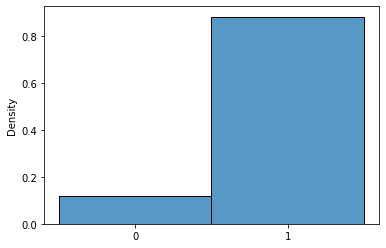

In [ ]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1,2]) # Constant output

# Sample 1000 actions
_actions = [epsilon_greedy(np.array([1,2,3,4]), DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0,1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### c) Loss Function

_Changed 2021-02-17: Added `gamma` explicitely to parameters_

In [ ]:
mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma=0.99):
    # TODO Implement loss function
    # qvals = ...
    qvals = []
    expected_qvals = []

    for i, (s, a, r, n_s, is_t) in enumerate(zip(states, actions, rewards, next_states, is_terminal)):
        qval = q_network(s)[a]
        n_a = np.argmax(q_network(n_s).detach())

        if is_t :
            expected_qval =  r + 0 * target_network(n_s)[n_a]
        else:
            expected_qval =  r + gamma * target_network(n_s)[n_a]
      
        qvals.append(qval)
        expected_qvals.append(expected_qval)

    qvals = torch.stack(qvals).float()
    expected_qvals = torch.stack(expected_qvals).float()

    loss = mse(qvals, expected_qvals)
    return loss

### d) Training

_Changed 2021-02-19: Properly call `compute_loss`_

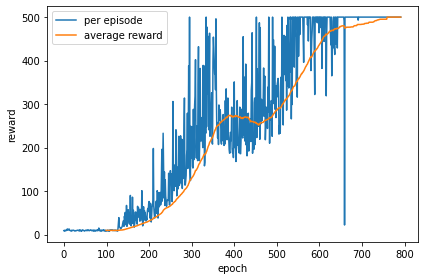

In [ ]:
# Hyperparameters
epsilon = 0.05  # For epsilon greedy action sampling
batch_size = 64
NETWORK_UPDATE_FREQUENCY = 4
NETWORK_SYNC_FREQUENCY = 100
gamma = 0.99
episodes = 10000
replay_buffer_size =  1000


q_network = DeepQNetwork()
target_network = deepcopy(q_network)
optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
mse = nn.MSELoss()

step_count = 0
total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        state, done = env.reset(), False
        rewards = []

        while not done:
            # Take a step
            action = epsilon_greedy(state, q_network, epsilon=epsilon)
            next_state, reward, done, _ = env.step(action)

            # Bookkeeping
            rewards.append(reward)
            buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and env._elapsed_steps < 500)
            state = next_state

            step_count += 1

            # Update network every NETWORK_UPDATE_FREQUENCY steps
            if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                # Sample batch of transitions
                state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                state_batch = torch.FloatTensor(state_batch)
                next_state_batch = torch.FloatTensor(next_state_batch)
                action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                terminal_batch = torch.BoolTensor(terminal_batch)

                # Compute loss
                loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
           
            # Sync networks every NETWORK_SYNC_FREQUENCY steps
            if step_count % NETWORK_SYNC_FREQUENCY == 0:
                # ********************
                # TODO Synchronize networks
                target_network.load_state_dict(q_network.state_dict())



                # ********************

        total_rewards.append(sum(rewards))

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")
        if np.mean(total_rewards[-100:]) == 500:
            break # Stop training

# Save model
with open("solution/b2d.pt", "wb") as f:
    torch.save(q_network, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b2d.png")

In [ ]:
# Test code
policy = q_network
policy.eval() # Switch to evaluation mode

def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps
        
_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

'ok (Average reward 500.00)'